In [1]:
import pandas as pd
import numpy as np
import psycopg2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# PostgreSQL Parameters
DBNAME = '99co'
USERNAME = 'postgres'
PASSWORD = 'postgres'

HOST = 'localhost'
PORT = '5432'

## Q1 - Write an SQL query that ranks districts by search volume
(if the search was for more than one district then each value in the list is counted as one search)

In [4]:
def get_search_vol():
    try:
        conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
        cur = conn.cursor()

        try:
            query = 'SELECT search_loc, COUNT(search_loc) as search_vol FROM search GROUP BY search_loc ORDER BY search_vol DESC;'
            cur.execute(query)
            return pd.DataFrame(cur.fetchall(), columns=['district', 'search_volume'])
        except:
            print('Error executing query')
    except:
        print('Error, Unable to connect to Database')

df_search_volume = get_search_vol()

In [5]:
df_search_volume.sample(5)

,district,search_volume
24,dtdistrict25,1231
2,dtdistrict15,9954
17,dtdistrict13,4199
23,dtdistrict28,1499
19,dtdistrict23,3200


Text(0, 0.5, 'District')

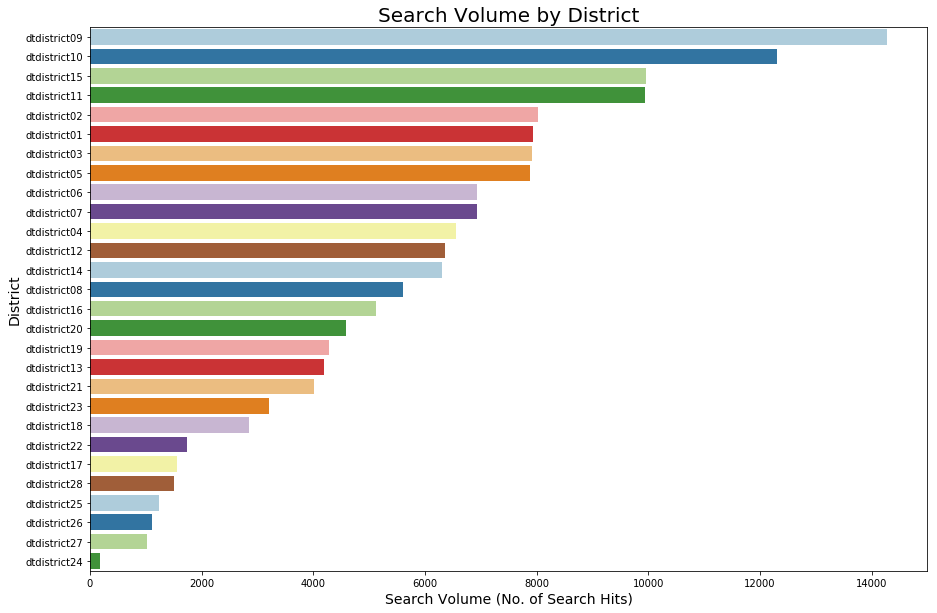

In [6]:
# Plot the Data
plt.figure(figsize=(15,10))
ax = plt.gca()
g = sns.barplot(ax=ax, y="district", x='search_volume', palette=sns.color_palette("Paired"), data=df_search_volume)

g.set_title('Search Volume by District', fontsize=20)
g.set_xlabel('Search Volume (No. of Search Hits)', fontsize=14)
g.set_ylabel('District', fontsize=14)

## Q2 - Which district had the highest day-on-day percent change in search volume and when did it occur?

In [7]:
def get_search_vol_date():
    try:
        conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
        cur = conn.cursor()

        try:
            query = 'SELECT search_time, search_loc, COUNT(search_loc) as search_vol FROM search GROUP BY search_time, search_loc ORDER BY search_loc, search_time ASC;'
            cur.execute(query)
            return pd.DataFrame(cur.fetchall(), columns=['search_time', 'district', 'search_volume'])
        except:
            print('Error executing query')
    except:
        print('Error, Unable to connect to Database')

df_search_volume_date = get_search_vol_date()

In [8]:
df_search_volume_date.sample(5)

,search_time,district,search_volume
334,2018-07-25,dtdistrict11,314
233,2018-07-17,dtdistrict08,154
163,2018-07-09,dtdistrict06,162
491,2018-07-27,dtdistrict16,29
580,2018-07-23,dtdistrict19,157


In [9]:
districts = df_search_volume['district'].value_counts().index.tolist()

In [10]:
df_search_volume_date.sample()

,search_time,district,search_volume
395,2018-07-24,dtdistrict13,133


In [11]:
# Calculate the Percentage Change on Day by Day Basis per District
df_search_volume_date['day_on_day_change'] = np.NaN
for district in districts:
    df_search_volume_date.loc[df_search_volume_date['district']==district, 'day_on_day_change'] = \
        df_search_volume_date[df_search_volume_date['district']==district]['search_volume'].pct_change()

In [12]:
# Select the Top Percentage Change on a Day by Day
df_search_vol_dod = df_search_volume_date.sort_values(by=['search_time', 'day_on_day_change'], ascending=False).groupby('search_time', as_index=False).first()

In [13]:
# Display the Percentage Change on a Day by Day for the first 5 days
df_search_vol_dod.head(5)

,search_time,district,search_volume,day_on_day_change
0,2018-07-01,dtdistrict01,670,NaN
1,2018-07-02,dtdistrict17,51,24.500000
2,2018-07-03,dtdistrict21,149,9.642857
3,2018-07-04,dtdistrict28,99,3.714286
4,2018-07-05,dtdistrict22,149,5.478261


In [14]:
# Prepare the Data for Plotting
df_search_vol_dod['top_district_date'] = df_search_vol_dod['search_time'].astype(str) + ' / ' + df_search_vol_dod['district']

Text(0.5, 0, 'Change Day on Day %')

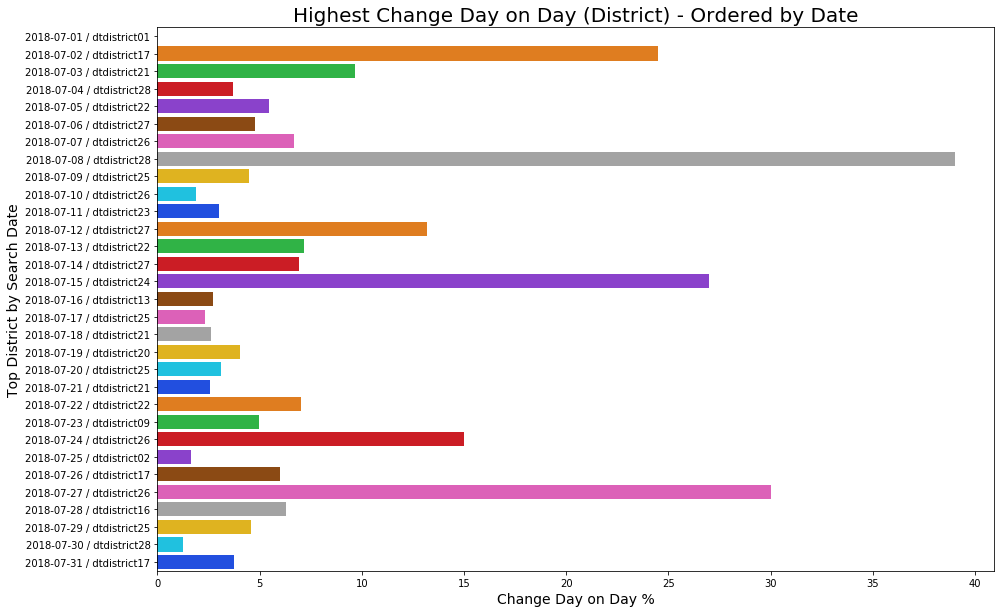

In [15]:
# Plot the Data
plt.figure(figsize=(15,10))
ax = plt.gca()
g = sns.barplot(ax=ax, x="day_on_day_change", y='top_district_date', palette='bright', data=df_search_vol_dod)

g.set_title('Highest Change Day on Day (District) - Ordered by Date', fontsize=20)
g.set_ylabel('Top District by Search Date', fontsize=14)
g.set_xlabel('Change Day on Day %', fontsize=14)

Text(0.5, 0, 'Change Day on Day %')

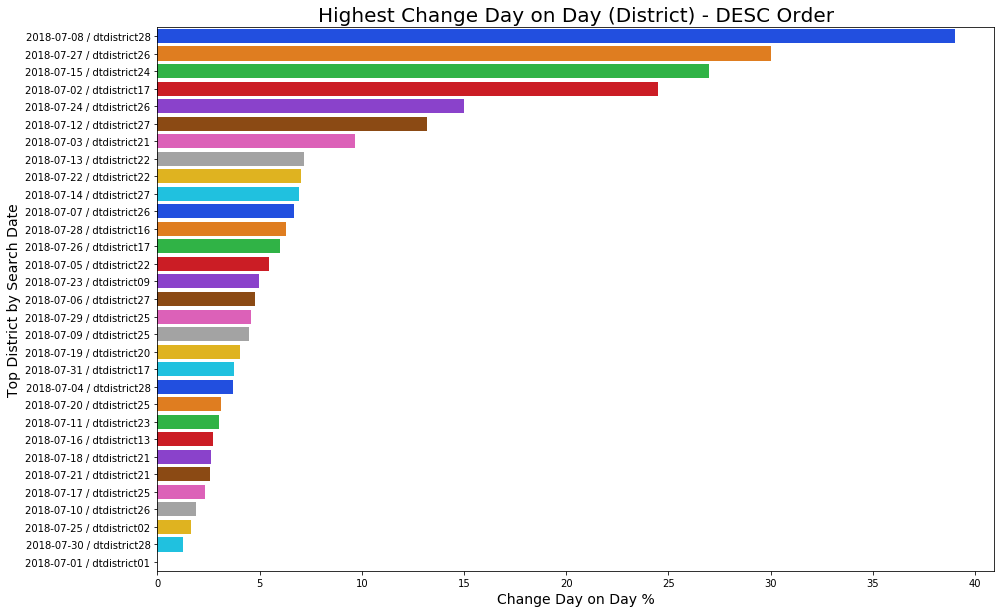

In [16]:
# Plot the Data
plt.figure(figsize=(15,10))
ax = plt.gca()
g = sns.barplot(ax=ax, x="day_on_day_change", y='top_district_date', palette='bright', data=df_search_vol_dod.sort_values('day_on_day_change', ascending=False))

g.set_title('Highest Change Day on Day (District) - DESC Order', fontsize=20)
g.set_ylabel('Top District by Search Date', fontsize=14)
g.set_xlabel('Change Day on Day %', fontsize=14)

## Q3 - How would you segment our user base based on their search behaviour?

In [17]:
def get_search_users():
    try:
        conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
        cur = conn.cursor()

        try:
            query = 'SELECT s.search_loc, s.listing_type, s.search_price_min, (s.search_price_min+s.search_price_max)/2 as search_price_mean, s.search_price_max, s.platform, s.property_type, u.user_type FROM search s LEFT JOIN users u ON s.user_id = u.user_id;'
            cur.execute(query)
            return pd.DataFrame(cur.fetchall(), columns=['search_loc', 'listing_type', 'search_price_min', 'search_price_mean', 'search_price_max', 'platform', 'property_type', 'user_type'])
        except:
            print('Error executing query')
    except:
        print('Error, Unable to connect to Database')

df_search_users = get_search_users()

In [18]:
df_search_users.sample(5)

,search_loc,listing_type,search_price_min,search_price_mean,search_price_max,platform,property_type,user_type
39083,dtdistrict16,room,0,450,900,web,landed,anon
55354,dtdistrict06,rent,0,3000,6000,web,condo,anon
141656,dtdistrict20,sale,1000000,1500000,2000000,web,hdb,anon
125125,dtdistrict06,rent,3000,4000,5000,web,condo,registered
17235,dtdistrict12,sale,1500000,2100000,2700000,web,condo,registered


Text(0.5, 1.0, 'Search Hits by User Type')

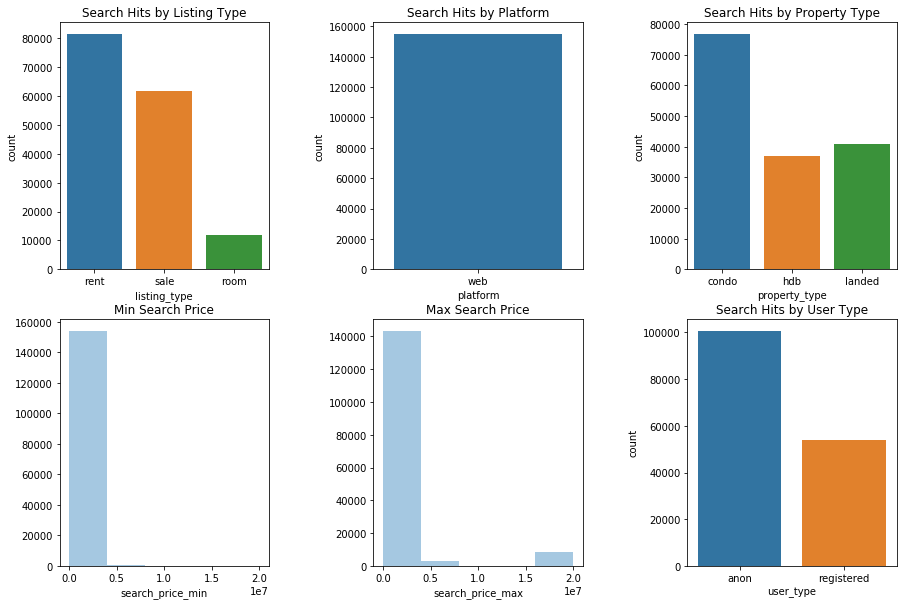

In [19]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
fig.subplots_adjust(wspace=0.5)

sns.countplot(x='listing_type', data=df_search_users, ax=ax[0][0])
ax[0][0].set_title('Search Hits by Listing Type')

sns.countplot(x='platform', data=df_search_users, ax=ax[0][1])
ax[0][1].set_title('Search Hits by Platform')

sns.countplot(x='property_type', data=df_search_users, ax=ax[0][2])
ax[0][2].set_title('Search Hits by Property Type')

sns.distplot(df_search_users['search_price_min'], bins=5, kde=False, ax=ax[1][0])
ax[1][0].set_title('Min Search Price')

sns.distplot(df_search_users['search_price_max'], bins=5, kde=False, ax=ax[1][1])
ax[1][1].set_title('Max Search Price')

sns.countplot(x='user_type', data=df_search_users, ax=ax[1][2])
ax[1][2].set_title('Search Hits by User Type')

Text(0.5, 0, 'Search Price (in 1k size)')

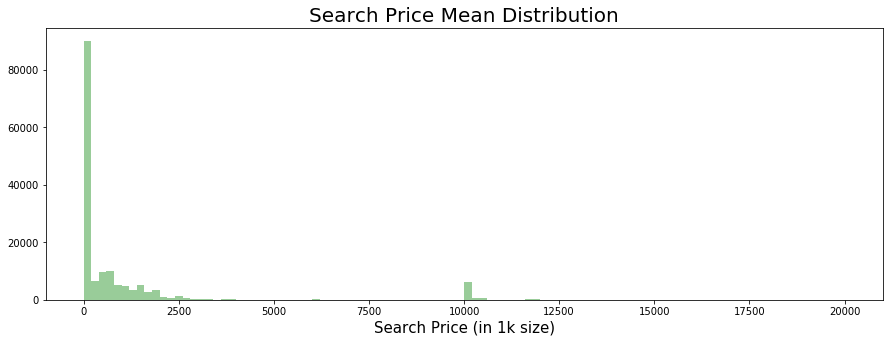

In [20]:
plt.figure(figsize=(15,5))
g = sns.distplot(df_search_users['search_price_mean']/1000, axlabel='Loan Amount', bins=100, color='g', kde=False)
g.set_title('Search Price Mean Distribution', fontsize=20)
g.set_xlabel('Search Price (in 1k size)', fontsize=15)

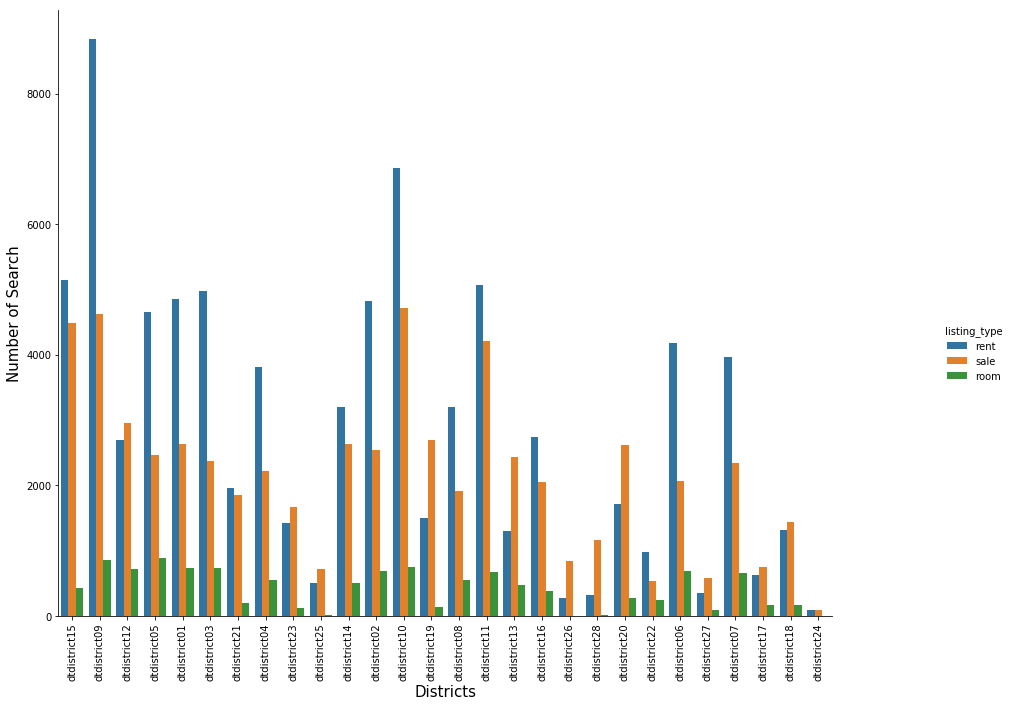

In [21]:
g = sns.catplot(x='search_loc', kind='count', data=df_search_users, hue='listing_type')
g.fig.set_size_inches(15, 10)
g.set_xticklabels(rotation=90)
g.set_xlabels('Districts', fontsize=15)
g.set_ylabels('Number of Search', fontsize=15)
g.set_titles('Loan Breakdown by Term and Status', fontsize=20)

### Summary
- Users are all from Web (we can discard this feature from future analysis just for this data)
- Most searches are looking for rent (hence non-local population)
    - Non-local population or expats tends to have preference for condos (more amenities), higher income bracket
- Search Price is difficult to interpret since it's aggregated between different listing types and property types
    - Can break this down later
- Most searches are anonymous (need to investigate if there are more features what would make them register, how to incentivise)
- In terms of listing, can assume that rent refers to whole unit rental, and room is rental by room basis
    - district09 has the highest whole unit rental and also sale followed by district10

### 1. By Listing Type (Search Price, Property Type across all Districts)

In [22]:
df_search_users.sample(5)

,search_loc,listing_type,search_price_min,search_price_mean,search_price_max,platform,property_type,user_type
74988,dtdistrict06,rent,2500,3000,3500,web,hdb,anon
33062,dtdistrict23,sale,0,650000,1300000,web,hdb,anon
56674,dtdistrict02,rent,5000,7000,9000,web,condo,registered
135814,dtdistrict13,sale,1000000,1500000,2000000,web,hdb,anon
37096,dtdistrict01,sale,0,300000,600000,web,landed,registered


In [23]:
df_search_sale = df_search_users[df_search_users['listing_type']=='sale']
df_search_sale = df_search_sale.groupby(['search_loc', 'property_type']).agg({'search_price_min':'mean', 'search_price_max':'mean'})
df_search_sale.reset_index(inplace=True)

In [24]:
df_search_sale.sample(10)

,search_loc,property_type,search_price_min,search_price_max
57,dtdistrict20,condo,382451.751251,2.246533e+06
12,dtdistrict05,condo,435923.344948,2.705049e+06
18,dtdistrict07,condo,463739.653875,2.509248e+06
39,dtdistrict14,condo,272509.986684,2.184864e+06
24,dtdistrict09,condo,631014.221557,3.061164e+06
2,dtdistrict01,landed,713059.006211,4.537610e+06
30,dtdistrict11,condo,565634.453782,2.942517e+06
69,dtdistrict24,condo,436538.461538,4.719231e+06
70,dtdistrict24,hdb,63636.363636,2.590909e+06
62,dtdistrict21,landed,379371.316306,4.124008e+06


### 1.1 Sale

Text(0, 0.5, 'Average Minimum Search Price')

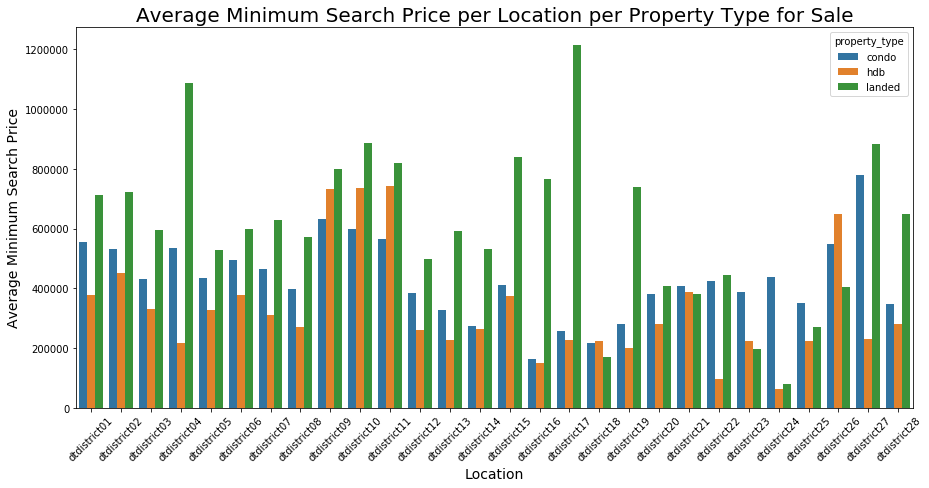

In [25]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='search_loc', y='search_price_min', hue='property_type', data=df_search_sale)
g.set_title('Average Minimum Search Price per Location per Property Type for Sale', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Average Minimum Search Price', fontsize=14)

Text(0, 0.5, 'Average Maximum Search Price')

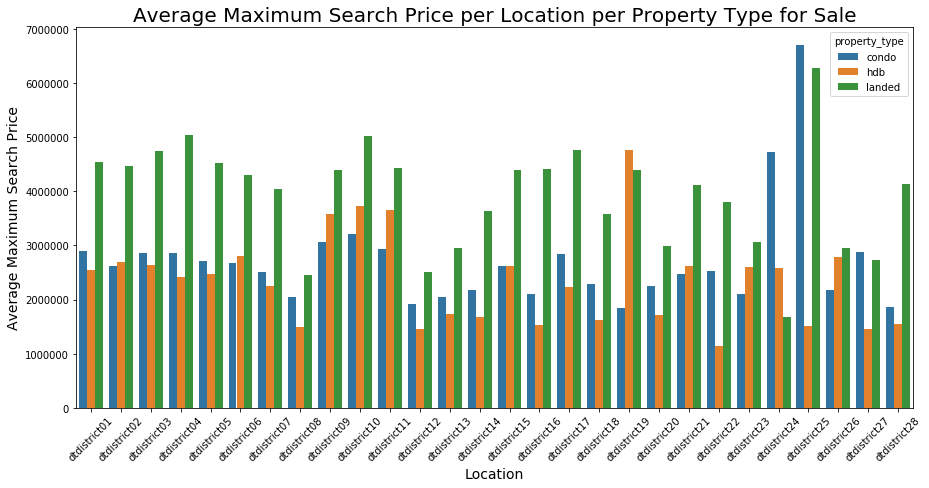

In [26]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='search_loc', y='search_price_max', hue='property_type', data=df_search_sale)
g.set_title('Average Maximum Search Price per Location per Property Type for Sale', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Average Maximum Search Price', fontsize=14)

### 1.2 Rent

In [27]:
df_search_rent = df_search_users[df_search_users['listing_type']=='rent']
df_search_rent = df_search_rent.groupby(['search_loc', 'property_type']).agg({'search_price_min':'mean', 'search_price_max':'mean'})
df_search_rent.reset_index(inplace=True)

Text(0, 0.5, 'Average Minimum Search Price')

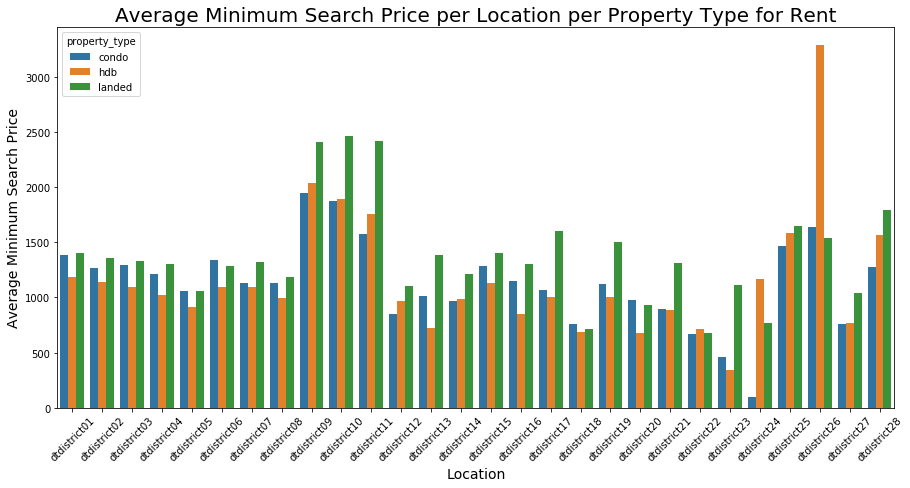

In [28]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='search_loc', y='search_price_min', hue='property_type', data=df_search_rent)
g.set_title('Average Minimum Search Price per Location per Property Type for Rent', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Average Minimum Search Price', fontsize=14)

Text(0, 0.5, 'Average Maximum Search Price')

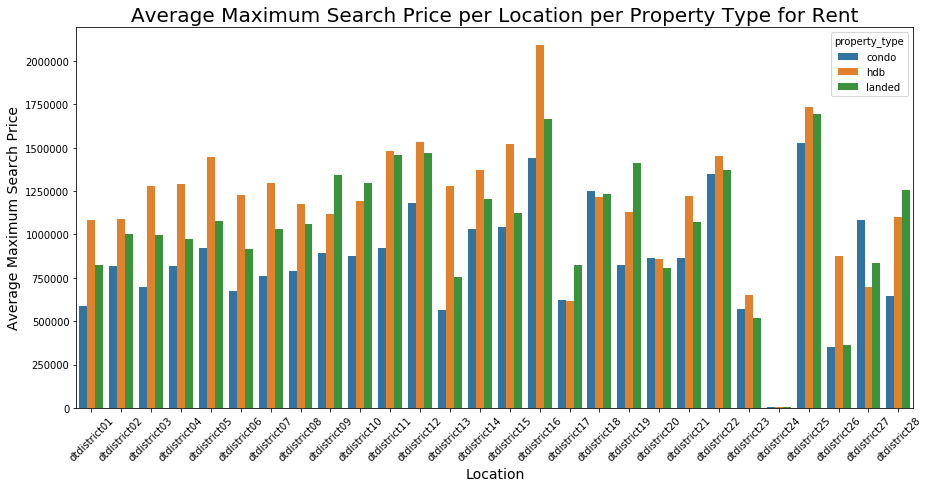

In [29]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='search_loc', y='search_price_max', hue='property_type', data=df_search_rent)
g.set_title('Average Maximum Search Price per Location per Property Type for Rent', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Average Maximum Search Price', fontsize=14)

### 1.3 Room

In [30]:
df_search_room = df_search_users[df_search_users['listing_type']=='room']
df_search_room = df_search_room.groupby(['search_loc', 'property_type']).agg({'search_price_min':'mean', 'search_price_max':'mean'})
df_search_room.reset_index(inplace=True)

Text(0, 0.5, 'Average Minimum Search Price')

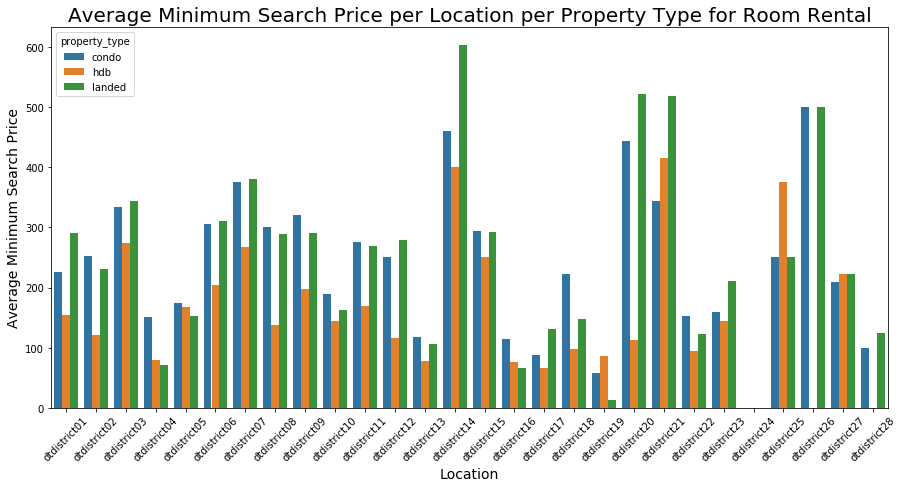

In [31]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='search_loc', y='search_price_min', hue='property_type', data=df_search_room)
g.set_title('Average Minimum Search Price per Location per Property Type for Room Rental', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Average Minimum Search Price', fontsize=14)

Text(0, 0.5, 'Average Maximum Search Price')

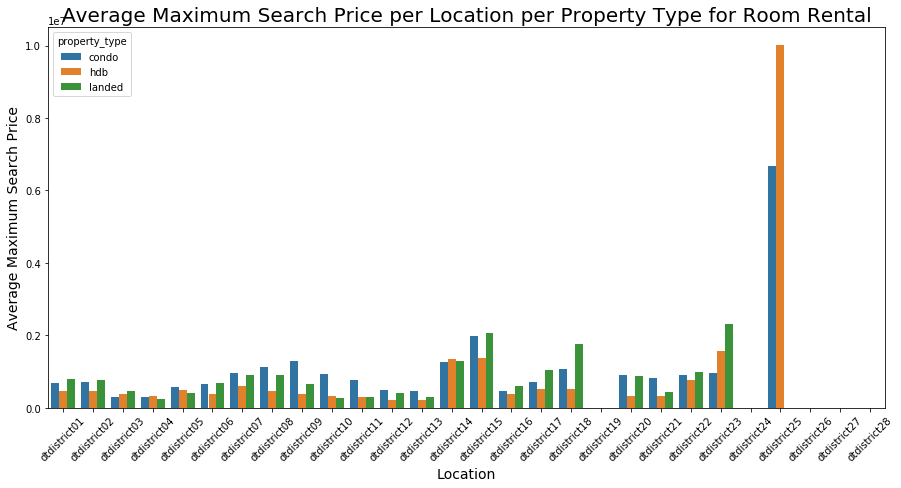

In [32]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='search_loc', y='search_price_max', hue='property_type', data=df_search_room)
g.set_title('Average Maximum Search Price per Location per Property Type for Room Rental', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Average Maximum Search Price', fontsize=14)

## Q4 - We want to drive conversions in the form of enquiries, what recommendations would you make to the Product Team?

In [33]:
def get_enquiries():
    try:
        conn = psycopg2.connect(database=DBNAME, user=USERNAME, password=PASSWORD, host=HOST, port=PORT)
        cur = conn.cursor()

        try:
            query = 'SELECT e.user_id, e.listing_id, l.listing_type, l.location, u.user_type, s.property_type, s.search_price_min, s.search_price_max from enquiries e LEFT JOIN listings l on e.listing_id = l.listing_id LEFT JOIN users u on e.user_id = u.user_id LEFT JOIN search s on e.user_id = s.user_id;'
            cur.execute(query)
            return pd.DataFrame(cur.fetchall(), columns=['user_id', 'listing_id', 'listing_type', 'location', 'user_type', 'property_type', 'search_price_min', 'search_price_max'])
        except:
            print('Error executing query')
    except:
        print('Error, Unable to connect to Database')

df_enquiries = get_enquiries()

In [34]:
df_enquiries.sample(5)

,user_id,listing_id,listing_type,location,user_type,property_type,search_price_min,search_price_max
217901,u2060,listing_2346,rent,dtdistrict03,registered,condo,0,5500
360364,u2102,listing_2604,rent,dtdistrict10,registered,condo,0,3000
412404,u2131,listing_2213,rent,dtdistrict10,registered,landed,2500,2500
571801,u685,listing_256,rent,dtdistrict19,registered,hdb,1000,1700
173780,u2060,listing_1380,rent,dtdistrict03,registered,landed,0,6000


(0.0, 1.0, 0.0, 1.0)

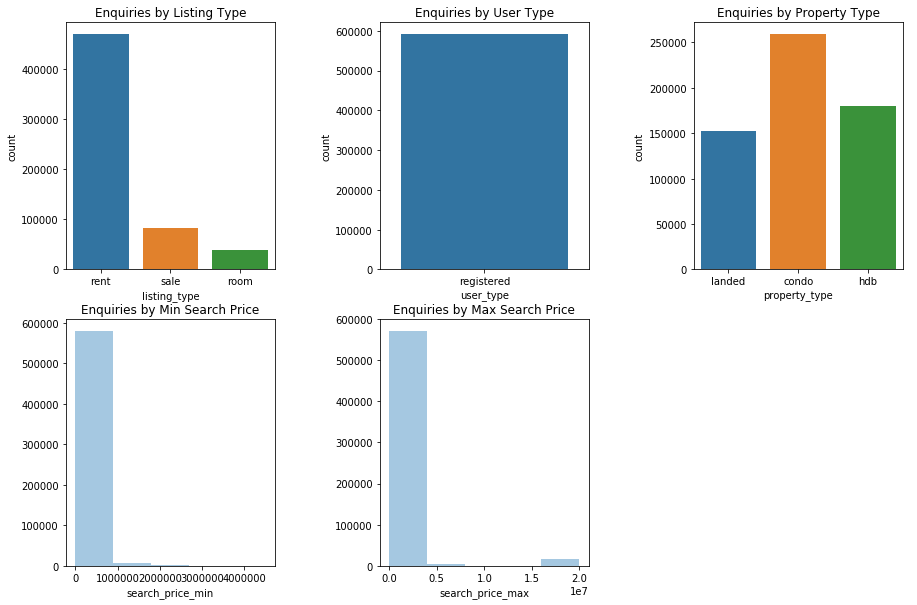

In [35]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
fig.subplots_adjust(wspace=0.5)

sns.countplot(x='listing_type', data=df_enquiries, ax=ax[0][0])
ax[0][0].set_title('Enquiries by Listing Type')

sns.countplot(x='user_type', data=df_enquiries, ax=ax[0][1])
ax[0][1].set_title('Enquiries by User Type')

sns.countplot(x='property_type', data=df_enquiries, ax=ax[0][2])
ax[0][2].set_title('Enquiries by Property Type')

sns.distplot(df_enquiries['search_price_min'], bins=5, kde=False, ax=ax[1][0])
ax[1][0].set_title('Enquiries by Min Search Price')

sns.distplot(df_enquiries['search_price_max'], bins=5, kde=False, ax=ax[1][1])
ax[1][1].set_title('Enquiries by Max Search Price')

ax[-1, -1].axis('off')

### Summary
- Enquiries are all registered users, can drop this feature
- Most enquiries are for rent (hence non-local population) in terms of volume
    - Need to check the commissions (if there are and if have, how to incentivise and make it attractive)
- By combining the search price with enquiries, we can gauge the price appetite of consumers (search to enquiry conversion and then potential deal)
- Most searches are anonymous (need to investigate if there are more features what would make them register, how to incentivise)

### 1. By Listing Type (Combine Enquiry with Search Price, Property Type across all Districts)

### 1.1 Sale

/home/neil/anaconda3/envs/DeepLearning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Minimum Enquiry Price')

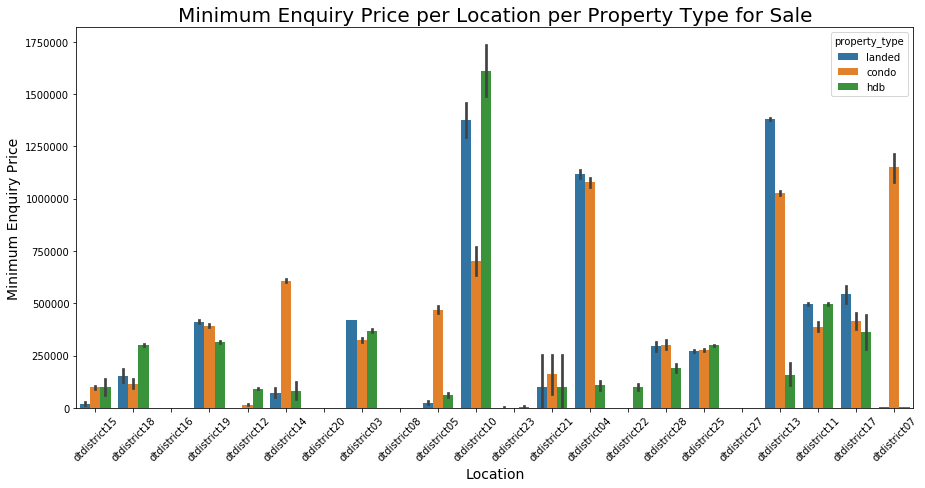

In [36]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='location', y='search_price_min', hue='property_type', data=df_enquiries[df_enquiries['listing_type']=='sale'])
g.set_title('Minimum Enquiry Price per Location per Property Type for Sale', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Minimum Enquiry Price', fontsize=14)

Text(0, 0.5, 'Maximum Enquiry Price')

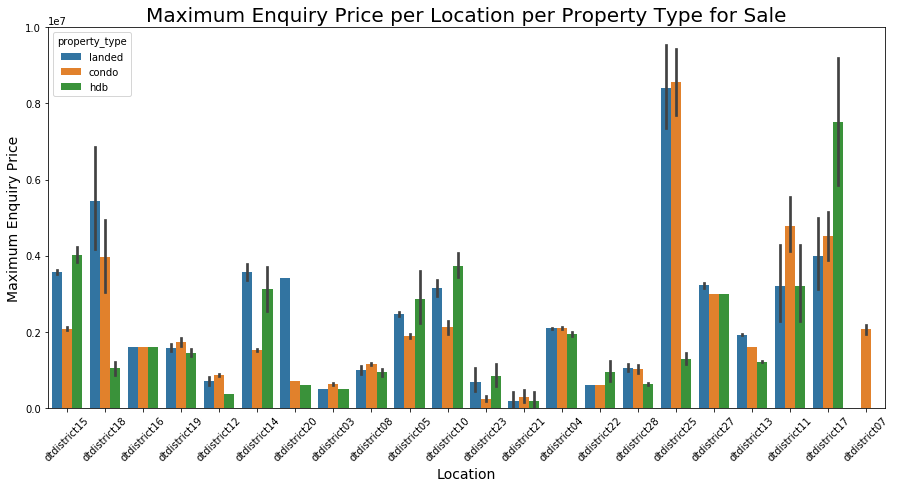

In [37]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='location', y='search_price_max', hue='property_type', data=df_enquiries[df_enquiries['listing_type']=='sale'])
g.set_title('Maximum Enquiry Price per Location per Property Type for Sale', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Maximum Enquiry Price', fontsize=14)

### 1.2 Rent

Text(0, 0.5, 'Minimum Enquiry Price')

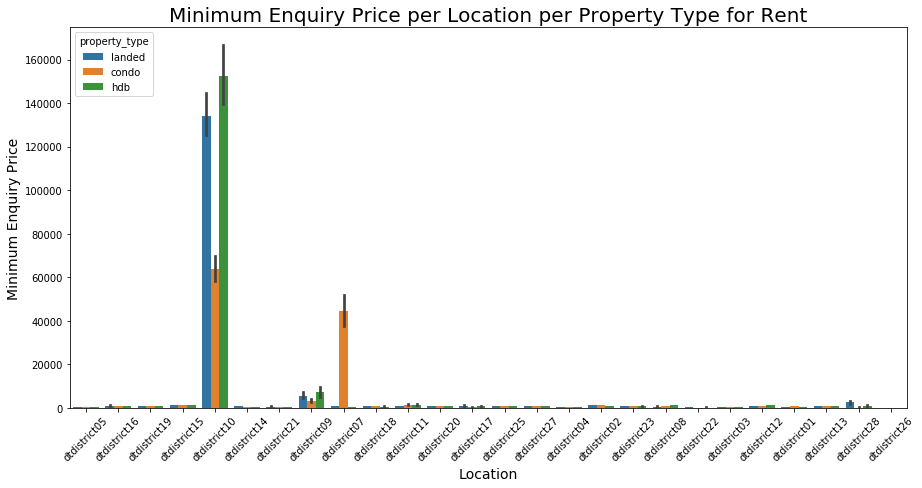

In [38]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='location', y='search_price_min', hue='property_type', data=df_enquiries[df_enquiries['listing_type']=='rent'])
g.set_title('Minimum Enquiry Price per Location per Property Type for Rent', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Minimum Enquiry Price', fontsize=14)

Text(0, 0.5, 'Maximum Enquiry Price')

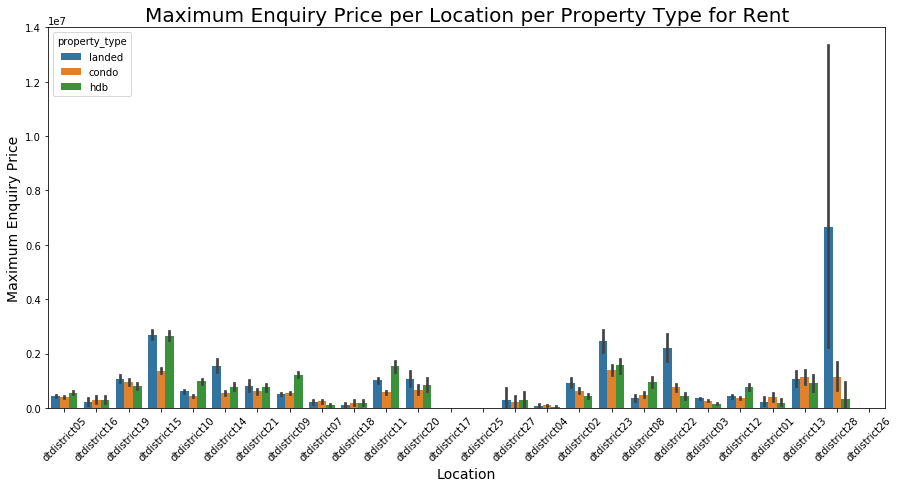

In [39]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='location', y='search_price_max', hue='property_type', data=df_enquiries[df_enquiries['listing_type']=='rent'])
g.set_title('Maximum Enquiry Price per Location per Property Type for Rent', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Maximum Enquiry Price', fontsize=14)

### 1.3 Room

Text(0, 0.5, 'Minimum Enquiry Price')

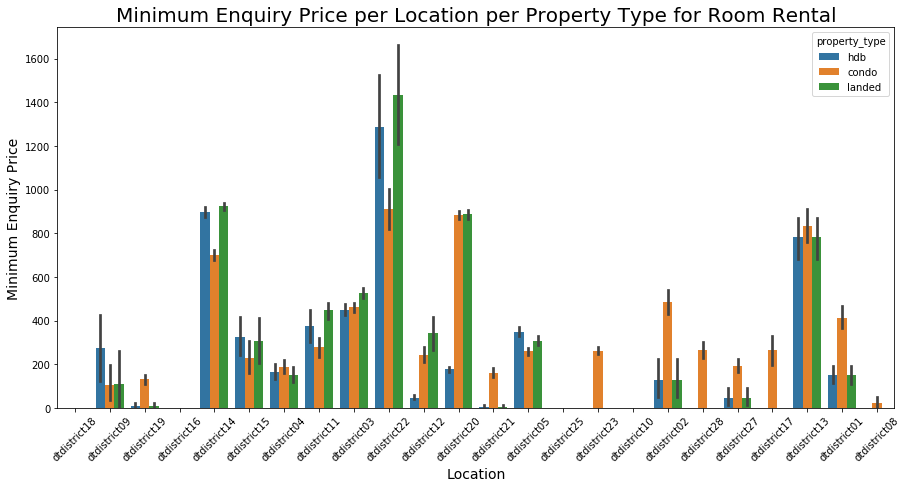

In [40]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='location', y='search_price_min', hue='property_type', data=df_enquiries[df_enquiries['listing_type']=='room'])
g.set_title('Minimum Enquiry Price per Location per Property Type for Room Rental', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Minimum Enquiry Price', fontsize=14)

Text(0, 0.5, 'Maximum Enquiry Price')

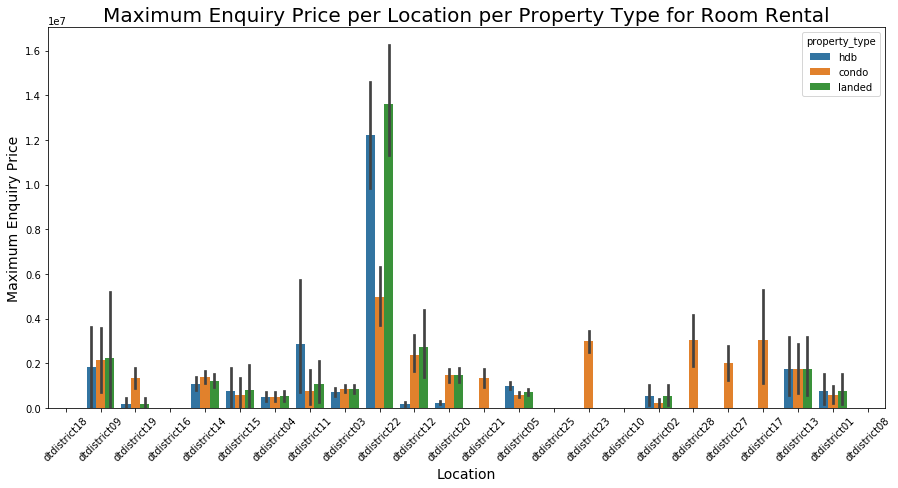

In [41]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
ax = plt.gca()
g = sns.barplot(x='location', y='search_price_max', hue='property_type', data=df_enquiries[df_enquiries['listing_type']=='room'])
g.set_title('Maximum Enquiry Price per Location per Property Type for Room Rental', fontsize=20)
g.set_xlabel('Location', fontsize=14)
g.set_ylabel('Maximum Enquiry Price', fontsize=14)